## Entanglement surface code

In this notebook, we will reproduce the experimental results of [Satzinger et al, Science 2021](https://www.science.org/doi/10.1126/science.abi8378) showing the realization of a surface code, and the demonstration of presence of long-range entanglement via the measurement of the topological entanglement entropy

In [1]:
using Revise
using ITensors,ITensorMPS
using RandomMeas
using ProgressMeter

A surface code of distance $d$ is made of $N=d^2$ qubits placed in a square lattice

In [2]:
d = 7#Code distance
N  = d^2; #number of physical qubits

# function to connect lattice coordinates to an index
# such that x = (i-1)%d+1 y = (i-1)÷d+1
g(x,y) = x+(y-1)*d 

g (generic function with 1 method)

The surface code is defined by a set of Plaquette $B_p=X_{i_1}X_{i_2}X_{i_3}X_{i_4}$ and $A_s=Z_{j_1}Z_{j_2}Z_{j_3}X_{j_4}$ operators (see graphics below). For the X plaquettes, we define the plaquette operators X_stab by the position of their lower left qubit, while X_stab_qubits stores all involved qubits.

In [3]:
#Positions of the X stabilizers
X_stab = Vector{Vector{Int}}()
X_stab_qubits = Vector{Vector{Int}}()
for y in 0:d
    start = (y+1)%2+1
    for x in start:2:d-1
        push!(X_stab,[x,y])
        qubits = Vector{Int}()
        for inx in 0:1
            for iny in 0:1
                xq = x+inx
                yq = y+iny
                if yq>0 && yq<d+1
                    push!(qubits,g(xq,yq))
                end
            end
        end
        push!(X_stab_qubits,qubits)
    end
end

We do the same for the $Z$ plaquettes.

In [4]:
Z_stab_qubits = Vector{Vector{Int}}()
Z_stab = Vector{Vector{Int}}()
for x in 0:d
    start = (x)%2+1
    for y in start:2:d-1
        push!(Z_stab,[x,y])
        qubits = Vector{Int}()
        for inx in 0:1
            for iny in 0:1
                xq = x+inx
                yq = y+iny
                if xq>0 && xq<d+1
                    push!(qubits,g(xq,yq))
                end
            end
        end
        push!(Z_stab_qubits,qubits)
    end
end

A graphical represenation of the qubits (red dots) and plaquette operators helps

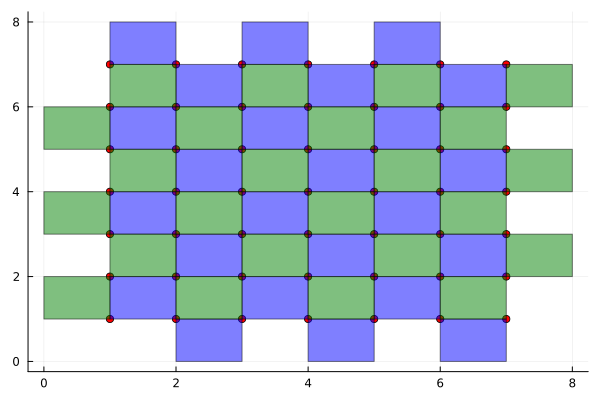

In [5]:
using Plots
plt = plot(leg=false)
scatter([X_stab[1][1]],[X_stab[1][2]])
for i in 1:N
    scatter!(plt,[(i-1)%d+1],[(i-1)÷d+1],mc=:red)
end
for X in X_stab
    plot!(plt,Shape(X[1] .+ [0,1,1,0], X[2] .+ [0,0,1,1]), fc=:blue, opacity=.5)
end
for Z in Z_stab
    plot!(plt,Shape(Z[1] .+ [0,1,1,0], Z[2] .+ [0,0,1,1]), fc=:green, opacity=.5)
end
display(plt)

To build the surface code numerically with ITensor, we initialize the state in the Z basis, and apply the projectors $1+B_p$ sequentially (in the Google experiment, one had to realize effectively this projection by a carefully designed gate sequence)

We obtain a surface with a bond dimension which scales as $2^d$ (The MPS representation provides an efficient compression along one spatial dimension)

In [6]:
ξ = siteinds("Qubit", N)
states = ["Up" for n in 1:N]
ψ = MPS(ξ,states);
@showprogress dt=1 for qubits in X_stab_qubits
    ampo = AutoMPO()
    ampo .+= "Id", qubits[1]
    if length(qubits)==2
        ampo .+= "X", qubits[1],"X",qubits[2]
    else
        ampo .+= "X", qubits[1],"X",qubits[2],"X",qubits[3],"X",qubits[4]
    end
    Proj = MPO(ampo,ξ)
    ψ = apply(Proj,ψ) # Application of the projector and normalization
    normalize!(ψ)
end
println("Surface code built with distance ", d," and bond dimension ",maxlinkdim(ψ))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:34


Surface code built with distance 7 and bond dimension 16


If our logical state is successfully created, all plaquette operators should have expectation value $+1$. This can be checked by sampling two bitstrings, one in the $Z$ basis, one in the $X$ basis. Note: Here we are simply interested in checking that we successfully created the state. For doing quantum error correction, one would use ancilla qubits to perform these measurements. 

In [7]:
orthogonalize!(ψ,1)
normalize!(ψ)
data_Z = sample(ψ)
expect_Z = Int[]
for qubits in Z_stab_qubits
    push!(expect_Z,(-1)^sum(data_Z[qubits] .-1))
end
println("number of Z errors ",sum(1. .-expect_Z)/2)

number of Z errors 0.0


In [8]:
gates = [op("H",ξt) for ξt in ξ]
ψx = apply(gates,ψ)
orthogonalize!(ψx,1)
normalize!(ψx)
data_X = sample(ψx)
expect_X = Int[]
for qubits in X_stab_qubits
    push!(expect_X,(-1)^sum(data_X[qubits] .-1))
end
println("number of X errors ",sum(1. .-expect_Z)/2)

number of X errors 0.0


The topological entanglement entropy can be defined by considering three neighboring partitions $A|B|C$
$S_{top}=S_A+S_B+S_C=S_{AB}-S_{BC}-S_{AC}+S_{ABC}$
where each entropy can be extracted from randomized measurements.

In [9]:

A = sort([g(3,3),g(3,4),g(3,5)])
B = sort([g(4,3),g(5,3),g(5,4)])
C = sort([g(4,4),g(4,5),g(5,5)])
AB  = sort([A;B])
BC  = sort([B;C])
AC  = sort([A;C])
ABC  = sort([A;B;C])
Part = [A,B,C,AB,AC,BC,ABC]

ρ = outer(ψ',ψ);

And then simulate the measurements. Notice that all entropies are integer because we are dealing with a Clifford state with flat entanglement spectrum.

In [10]:
ITensors.disable_warn_order()
nu = 2000
NM = 1000

nb = length(Part)
S = zeros(nb)
S_e = zeros(nb)
@showprogress dt=1 for ib in 1:nb
    P = Part[ib]
    NP = length(P)
    data = zeros(Int8,(nu,NM,NP))
    ρP,ξP = reduce_dm(ρ,P);
    for r in 1:nu
        u = get_rotations(ξP,1) #Haar rotations in A
        data[r,:,:] = get_RandomMeas(ρP,u,NM);
    end
    S_e[ib] = -log2(get_purity(ρP))
    S[ib] = -log2(get_purity_hamming(data,ξP))
    println("Partition: ", P, "| Entropy = " , S[ib])
end

Partition: [17, 24, 31]| Entropy = 2.9990017405345175


Progress:  29%|███████████▊                             |  ETA: 0:01:16

Partition: [18, 19, 26]| Entropy = 2.999468666189997


Progress:  43%|█████████████████▋                       |  ETA: 0:00:53

Partition: [25, 32, 33]| Entropy = 2.998968317793085


Progress:  57%|███████████████████████▍                 |  ETA: 0:01:32

Partition: [17, 18, 19, 24, 26, 31]| Entropy = 6.010210364415663


Progress:  71%|█████████████████████████████▎           |  ETA: 0:00:57

Partition: [17, 24, 25, 31, 32, 33]| Entropy = 4.976372071667561


Progress:  86%|███████████████████████████████████▏     |  ETA: 0:00:29

Partition: [18, 19, 25, 26, 32, 33]| Entropy = 4.09963527307895


Progress: 100%|█████████████████████████████████████████| Time: 0:04:34


Partition: [17, 18, 19, 24, 25, 26, 31, 32, 33]| Entropy = 5.188883920826664


In [11]:
println("Expected topological entanglement entropy ", S_e[1]+S_e[2]+S_e[3]-S_e[4]-S_e[5]-S_e[6]+S_e[7])
println("Measured topological entanglement entropy ", S[1]+S[2]+S[3]-S[4]-S[5]-S[6]+S[7])

Expected topological entanglement entropy -1.0000000000000409
Measured topological entanglement entropy -0.8998950638179091
